In [ ]:
!pip install -q transformers
!pip install pydot
!pip install -U scikit-learn
!pip install datasets
!pip install ipynb

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from datasets import load_dataset
from transformers import DebertaTokenizer, TFDebertaModel, TFRobertaForSequenceClassification, RobertaTokenizer

## Load Dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
dataset = load_dataset('parquet', data_files={'train': ['yelp_review_trainset_subset.parquet'],'test': 'yelp_review_testset_subset.parquet'})

train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

display(len(train_labels), len(test_labels))

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

1500

250

In [ ]:
train_labels

array([0, 0, 0, ..., 4, 4, 4])

## Load RoBERTa Model & Tokenization

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
roberta_train_encodings = roberta_tokenizer(train_texts, truncation=True, padding=True, max_length=200, return_tensors='tf')
roberta_test_encodings = roberta_tokenizer(test_texts, truncation=True, padding=True, max_length=200, return_tensors='tf')
nptest_labels = np.asarray(test_labels)

## Define a customized model with RoBERTa

In [ ]:
def create_roberta_multiclass_model(checkpoint = model,
                                 num_classes = 5,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                 max_length = 200):

    # Input Preparations
    roberta_input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    roberta_attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': roberta_input_ids,
            'attention_mask': roberta_attention_mask}

    # Roberta
    roberta_out = model(roberta_input_ids, output_hidden_states=True)

    # Pooler Token
    pooler_token = roberta_out.hidden_states[-1]
    pooler_token = pooler_token[:,0]

    # Hidden Layers
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Classification Layers
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[roberta_input_ids, roberta_attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                metrics='accuracy')

    return classification_model

In [ ]:
pooler_roberta_model = create_roberta_multiclass_model(checkpoint=model, num_classes=5, max_length=200)
pooler_roberta_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_layer (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246494   ['input_ids_layer[0][0]']     
 assification (TFRobertaFor  (loss=None, logits=(None,    77                                      
 SequenceClassification)     5),                                                                  
                              hidden_states=((None, 200                                           
                             , 768),                                                          

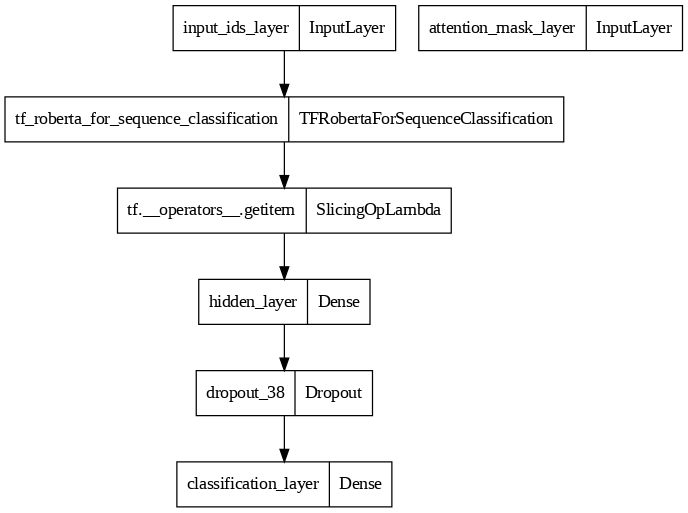

In [ ]:
keras.utils.plot_model(pooler_roberta_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

## Train the model

In [ ]:
pooler_roberta_model_history = pooler_roberta_model.fit([roberta_train_encodings.input_ids, roberta_train_encodings.attention_mask],
                                        train_labels,
                                        validation_data=([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask],
                                        nptest_labels),
                                        batch_size=30,
                                        epochs=3)

Epoch 1/3


50/50 [==============================] - 159s 2s/step - loss: 1.5660 - accuracy: 0.2813 - val_loss: 1.1361 - val_accuracy: 0.4480
Epoch 2/3
50/50 [==============================] - 70s 1s/step - loss: 1.1319 - accuracy: 0.5047 - val_loss: 1.0427 - val_accuracy: 0.5320
Epoch 3/3
50/50 [==============================] - 69s 1s/step - loss: 0.9241 - accuracy: 0.6113 - val_loss: 1.0747 - val_accuracy: 0.5480


## Display prediction result

In [ ]:
score = pooler_roberta_model.evaluate([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask],test_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 3s 416ms/step - loss: 1.0747 - accuracy: 0.5480
Test loss: 1.0747255086898804
Test accuracy: 0.5479999780654907


## Display Confusion Matrix

In [ ]:
roberta_predictions_model = pooler_roberta_model.predict([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask])
roberta_predictions_model = tf.argmax(roberta_predictions_model, axis=-1)
print(classification_report(test_labels, roberta_predictions_model.numpy(), target_names=["Star 0","Star 1","Star 2","Star 3","Star 4"]))

8/8 [==============================] - 15s 416ms/step
              precision    recall  f1-score   support

      Star 0       0.54      0.74      0.62        50
      Star 1       0.50      0.28      0.36        50
      Star 2       0.58      0.42      0.49        50
      Star 3       0.46      0.48      0.47        50
      Star 4       0.63      0.82      0.71        50

    accuracy                           0.55       250
   macro avg       0.54      0.55      0.53       250
weighted avg       0.54      0.55      0.53       250



Text(220.72222222222223, 0.5, 'True')

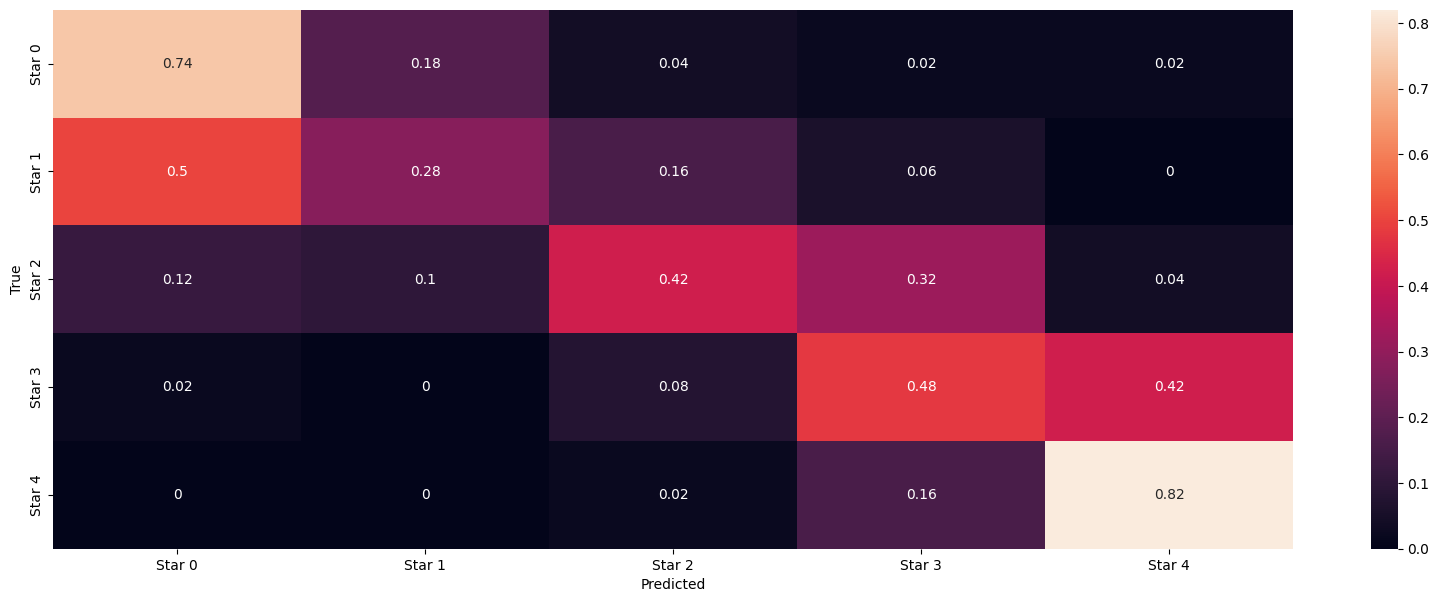

In [ ]:
cm = tf.math.confusion_matrix(test_labels, roberta_predictions_model)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Star 0","Star 1","Star 2","Star 3","Star 4"],
    yticklabels=["Star 0","Star 1","Star 2","Star 3","Star 4"])
plt.xlabel("Predicted")
plt.ylabel("True")

## Add Weijie's BERT model

In [ ]:
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

model_checkpoint = 'microsoft/deberta-base'

deberta_tokenizer = DebertaTokenizer.from_pretrained(model_checkpoint)
deberta_model = TFDebertaModel.from_pretrained(model_checkpoint)

deberta_train_encodings = deberta_tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors='tf')
deberta_test_encodings = deberta_tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors='tf')
nptest_labels = np.asarray(test_labels)


def create_deberta_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = 5,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                 max_length = 128):

    # Input Preparations
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask}

    # Bert
    bert_out = deberta_model(bert_inputs, output_hidden_states=True)

    # Pooler Token
    pooler_token = bert_out.hidden_states[-1]
    pooler_token = pooler_token[:,0]

    # Hidden Layers
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Classification Layers
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                metrics='accuracy')

    return classification_model

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


In [ ]:
pooler_deberta_model = create_deberta_multiclass_model(checkpoint=model_checkpoint, num_classes=5, max_length=128)
pooler_deberta_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                    

In [ ]:
pooler_deberta_model_history = pooler_deberta_model.fit([deberta_train_encodings.input_ids, deberta_train_encodings.token_type_ids, deberta_train_encodings.attention_mask],
                                        train_labels,
                                        validation_data=([deberta_test_encodings.input_ids, deberta_test_encodings.token_type_ids, deberta_test_encodings.attention_mask],
                                        nptest_labels),
                                        batch_size=30,
                                        epochs=3)

Epoch 1/3


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


50/50 [==============================] - 163s 2s/step - loss: 1.7924 - accuracy: 0.1967 - val_loss: 1.6101 - val_accuracy: 0.2000
Epoch 2/3
50/50 [==============================] - 57s 1s/step - loss: 1.7068 - accuracy: 0.2420 - val_loss: 1.3505 - val_accuracy: 0.4400
Epoch 3/3
50/50 [==============================] - 55s 1s/step - loss: 1.2856 - accuracy: 0.4313 - val_loss: 1.3709 - val_accuracy: 0.5000


## Ensemble Learning

In [ ]:
roberta_predictions_model = pooler_roberta_model.predict([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask])
deberta_predictions_model = pooler_deberta_model.predict([deberta_test_encodings.input_ids, deberta_test_encodings.token_type_ids, deberta_test_encodings.attention_mask])

8/8 [==============================] - 32s 313ms/step


### 1.0 Ensemble Learning - Averaging

In [ ]:
avg_pred = (roberta_predictions_model + deberta_predictions_model)/2
avg_pred = np.argmax(avg_pred, axis=1)
print(classification_report(test_labels, avg_pred, target_names=["Star 0","Star 1","Star 2","Star 3","Star 4"]))

              precision    recall  f1-score   support

      Star 0       0.55      0.90      0.68        50
      Star 1       0.64      0.36      0.46        50
      Star 2       0.66      0.42      0.51        50
      Star 3       0.43      0.26      0.33        50
      Star 4       0.58      0.90      0.70        50

    accuracy                           0.57       250
   macro avg       0.57      0.57      0.54       250
weighted avg       0.57      0.57      0.54       250

